Car Insurance Claim Prediction
Objective: To build a predictive model that determines whether a customer will make a car insurance claim in the next policy period.

Domain: Insurance / Finance / Risk Analytics.

1. Library Imports
In this section, I am importing all the core libraries needed for data manipulation, visualization, and machine learning. I have added joblib for saving the model and plotly for the dashboard components.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import joblib

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

print("All libraries imported successfully!")

All libraries imported successfully!


2. Data Ingestion
In this section, I load the raw insurance dataset. This is the foundation of the project. I will verify the shape of the data to ensure it loaded correctly.

In [2]:
# data loading
train_df = pd.read_csv('train.csv')

# Verification
print(f"Data loaded successfully. Shape: {train_df.shape}")
train_df.head()

Data loaded successfully. Shape: (58592, 44)


,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
2,ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
3,ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
4,ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,...,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0


3. Data Cleaning & Export for Dashboard
Before building the model, we must handle the data. Crucially, I am exporting a copy of the data here to a CSV file. This is the exact step that was missing and caused your FileNotFoundError in the Streamlit app

In [3]:
# missing val check 
print(train_df.isnull().sum().sum(), "missing values found.")

# Save the data for the dashboard 
train_df.to_csv('insurance_dashboard_final.csv', index=False)
print("File 'insurance_dashboard_final.csv' created and ready for Streamlit!")

0 missing values found.
File 'insurance_dashboard_final.csv' created and ready for Streamlit!


4. Data Profiling and Integrity Check
This step involves an in-depth look at the dataset's structure. By calling .info(), I can verify the data types (integers, floats, or objects) for all 44 columns and ensure they are appropriate for machine learning. Additionally, calculating the sum of null values per column is a critical "Data Cleaning" requirement; it confirms whether we need to perform imputation or if the dataset is already complete and ready for the preprocessing pipeline.

In [4]:
# checking for data type and non-null vals
train_df.info()

# to count missing vals per column
print(train_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 44 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         58592 non-null  object 
 1   policy_tenure                     58592 non-null  float64
 2   age_of_car                        58592 non-null  float64
 3   age_of_policyholder               58592 non-null  float64
 4   area_cluster                      58592 non-null  object 
 5   population_density                58592 non-null  int64  
 6   make                              58592 non-null  int64  
 7   segment                           58592 non-null  object 
 8   model                             58592 non-null  object 
 9   fuel_type                         58592 non-null  object 
 10  max_torque                        58592 non-null  object 
 11  max_power                         58592 non-null  object 
 12  engi

5.  Statistical Summary and Data Distribution
In this section, I am generating descriptive statistics for all numerical columns using the .describe() function. This provides a high-level overview of the data's central tendency (mean, median), dispersion (standard deviation), and range (min, max). These statistics are vital for identifying potential outliers and understanding the scale of features like policy_tenure and age_of_car, which helps determine if feature scaling (like StandardScaler) will be necessary during the model building phase.

In [5]:
# stats for columns
train_df.describe()

,policy_tenure,age_of_car,age_of_policyholder,population_density,make,airbags,displacement,cylinder,gear_box,turning_radius,length,width,height,gross_weight,ncap_rating,is_claim
count,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.00000,58592.000000,58592.000000,58592.000000
mean,0.611246,0.069424,0.469420,18826.858667,1.763722,3.137066,1162.355851,3.626963,5.245443,4.852893,3850.476891,1672.233667,1553.33537,1385.276813,1.759950,0.063968
std,0.414156,0.056721,0.122886,17660.174792,1.136988,1.832641,266.304786,0.483616,0.430353,0.228061,311.457119,112.089135,79.62227,212.423085,1.389576,0.244698
min,0.002735,0.000000,0.288462,290.000000,1.000000,1.000000,796.000000,3.000000,5.000000,4.500000,3445.000000,1475.000000,1475.00000,1051.000000,0.000000,0.000000
25%,0.210250,0.020000,0.365385,6112.000000,1.000000,2.000000,796.000000,3.000000,5.000000,4.600000,3445.000000,1515.000000,1475.00000,1185.000000,0.000000,0.000000
50%,0.573792,0.060000,0.451923,8794.000000,1.000000,2.000000,1197.000000,4.000000,5.000000,4.800000,3845.000000,1735.000000,1530.00000,1335.000000,2.000000,0.000000
75%,1.039104,0.110000,0.548077,27003.000000,3.000000,6.000000,1493.000000,4.000000,5.000000,5.000000,3995.000000,1755.000000,1635.00000,1510.000000,3.000000,0.000000
max,1.396641,1.000000,1.000000,73430.000000,5.000000,6.000000,1498.000000,4.000000,6.000000,5.200000,4300.000000,1811.000000,1825.00000,1720.000000,5.000000,1.000000


6. Target Variable Visualization and Class Imbalance Analysis
In this section, I am visualizing the distribution of the target variable, is_claim. This is a crucial step in the Exploratory Data Analysis (EDA) phase. By using a count plot and calculating the percentage of each class, I can determine if the dataset is imbalanced. In insurance datasets, "No Claims" (0) typically far outnumber "Claims" (1). Identifying this imbalance early is vital because it informs the machine learning strategy, specifically the need for techniques like adjusting scale_pos_weight in the XGBoost model to ensure the algorithm doesn't ignore the minority "Claim" class.

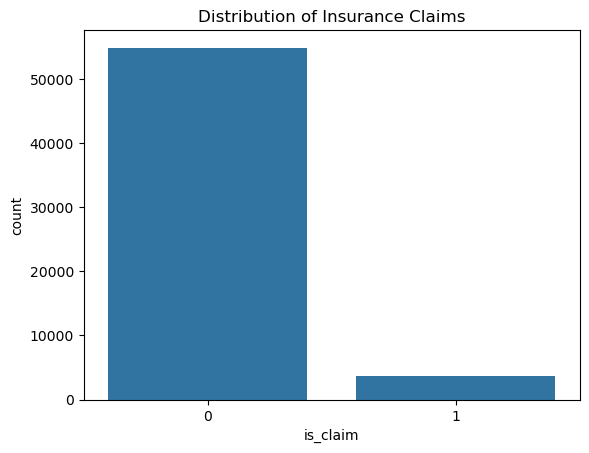

is_claim
0    93.603222
1     6.396778
Name: proportion, dtype: float64


In [6]:
# vis the target var distribution
sns.countplot(x='is_claim', data=train_df)
plt.title('Distribution of Insurance Claims')
plt.show()

# Print percentage of claims
print(train_df['is_claim'].value_counts(normalize=True) * 100)

7. Bivariate Analysis: Relationship Between Numerical Features and Claims
In this section, I am performing bivariate analysis by comparing key numerical features—policy_tenure, age_of_car, and age_of_policyholder—against the target variable (is_claim). By using boxplots, I can visualize the distribution, median, and potential outliers for each group. This helps in understanding if specific factors, such as an older car or a longer policy tenure, correlate with a higher likelihood of a claim. This visual evidence is crucial for Feature Selection, as it highlights which variables have the most predictive power for the model.

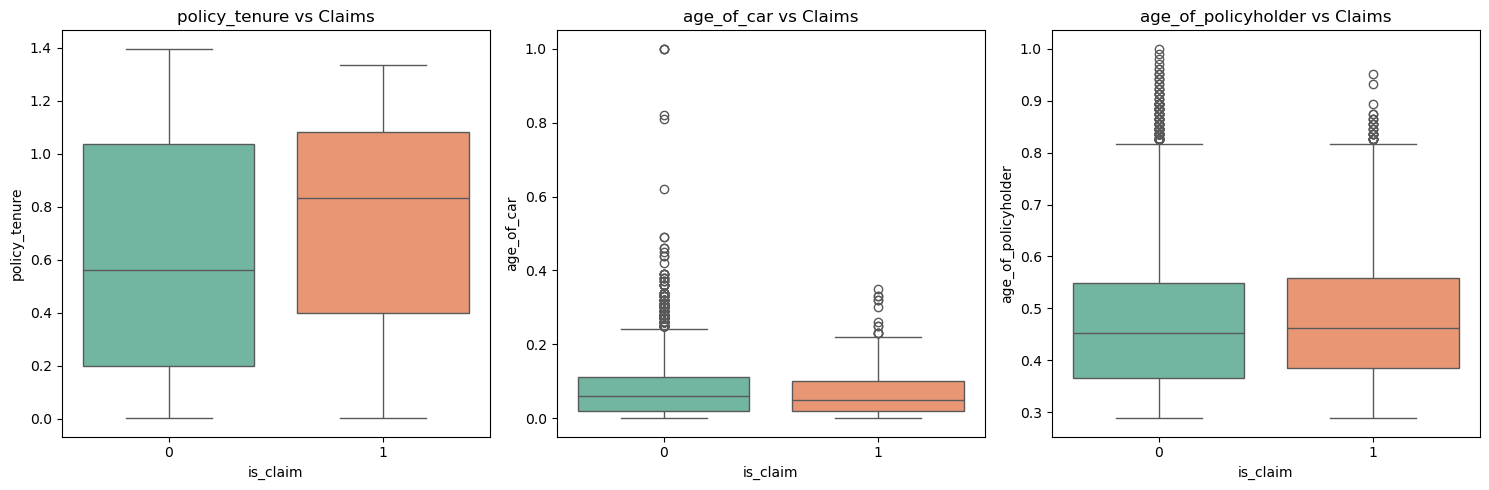

In [7]:
# 1. Analyse Numerical Features
cols_to_plot = ['policy_tenure', 'age_of_car', 'age_of_policyholder']

plt.figure(figsize=(15, 5))
for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='is_claim', y=col, data=train_df, hue='is_claim', palette='Set2', legend=False)
    plt.title(f'{col} vs Claims')

plt.tight_layout()
plt.show()

8. Categorical Feature Analysis: Risk Assessment by Area Cluster
In this section, I am analyzing the relationship between the geographical location (area_cluster) and the frequency of insurance claims. By calculating the mean of the is_claim variable for each cluster, I am effectively determining the "Risk Percentage" per area. I have added a horizontal dashed line representing the overall average risk across the entire dataset. This visualization allows us to identify "High-Risk" clusters that deviate significantly from the norm, providing critical insights for Geospatial Risk Modeling and helping the insurance company decide where to adjust premiums.

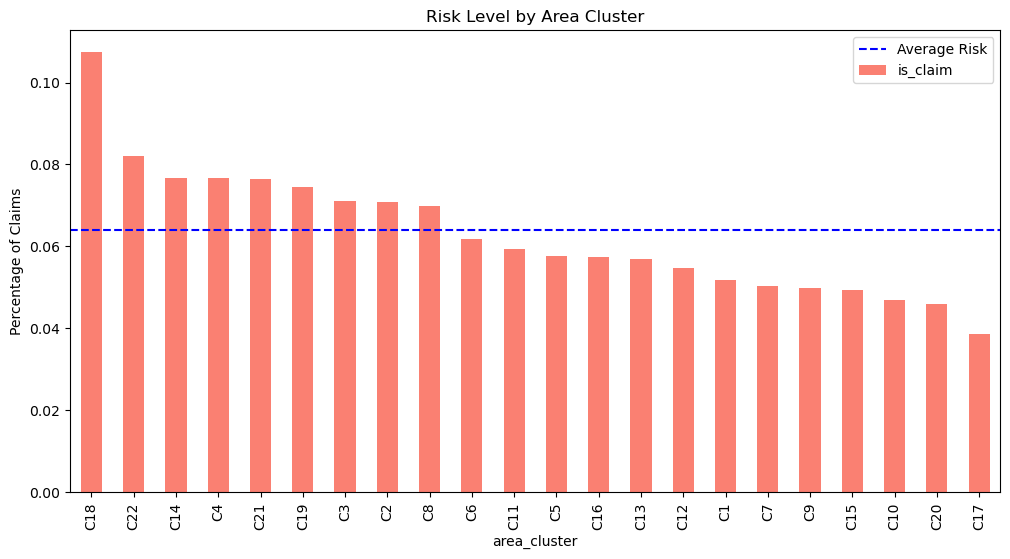

In [8]:
# Analys of Categorical Featurs - Area Cluster vs Claims
plt.figure(figsize=(12, 6))
# to cal the perc of claims in each area
area_risk = train_df.groupby('area_cluster')['is_claim'].mean().sort_values(ascending=False)
area_risk.plot(kind='bar', color='salmon')
plt.title('Risk Level by Area Cluster')
plt.ylabel('Percentage of Claims')
plt.axhline(train_df['is_claim'].mean(), color='blue', linestyle='--', label='Average Risk')
plt.legend()
plt.show()

9. Preprocessing Pipeline and Feature Engineering
In this stage, I am building an automated Preprocessing Pipeline to handle the diverse data types in the insurance dataset. To ensure the model performs optimally, I have separated the features into numerical and categorical groups.

Numerical Features: Are passed through a StandardScaler to ensure all values are on the same scale, preventing features with larger numbers from dominating the model.

Categorical Features: Are processed using OneHotEncoder, converting text labels into a numerical format that the machine learning algorithm can understand.

By wrapping these steps into a ColumnTransformer, I create a reproducible workflow that prevents Data Leakage and ensures that any new data (like user inputs in the Streamlit app) is treated exactly the same way as the training data.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 1. Define Features (X) and Target (y)
X = train_df.drop(['policy_id', 'is_claim'], axis=1)
y = train_df['is_claim']

# 2. Identify column type automatically
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# 3. Creating transformer
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 4. group them into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("Preprocessing Pipeline successfully defined!")

Preprocessing Pipeline successfully defined!


10. Data Splitting and Stratification
In this critical step, I am partitioning the dataset into a Training Set (80%) and a Validation Set (20%).

test_size=0.2: Reserves 20% of the data to test the model's performance on unseen information.

random_state=42: Ensures reproducibility, so the results remain consistent every time the code is run.

stratify=y: This is the most important parameter here. Because our insurance dataset is imbalanced (fewer claims than non-claims), stratification ensures that the proportion of claims is identical in both the training and validation sets. This prevents the model from being trained on a skewed sample, which is a key requirement for building a reliable Predictive Model.

In [10]:
# Spliting  the data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training rows: {X_train.shape[0]}")
print(f"Validation rows: {X_val.shape[0]}")

Training rows: 46873
Validation rows: 11719


11. Model Training: Cost-Sensitive XGBoost Learning
In this stage, I am training the XGBoost Classifier, an advanced gradient boosting algorithm known for its high performance in tabular data competitions.

To address the significant Class Imbalance (where only ~6% of policies result in a claim), I have implemented several strategic hyperparameter settings:

scale_pos_weight=15: This is a critical adjustment for imbalanced data. It tells the model to treat each "Claim" (1) as 15 times more important than a "No Claim" (0). This effectively penalizes the model more heavily for missing a claim, helping to improve the Recall of the minority class.

max_depth=5: Limits the complexity of each tree to prevent overfitting on the training data.

learning_rate=0.1: Controls the step size at each iteration, allowing the model to converge steadily.

Pipeline Integration: By combining the preprocessor and xgb_model into a single clf_pipeline, I ensure that all transformations (scaling and encoding) are applied automatically during both training and future predictions.

In [12]:
from xgboost import XGBClassifier

# 1. Define the XGBoost model
# We set scale_pos_weight=15 because claims are roughly 6% of the data
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=15, 
    random_state=42,
    eval_metric='logloss'
)

# 2. make preprocessing and model into one pipeline
# makes sure training and validation data are treated same
clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_model)
])

# 3. Fit the model
clf_pipeline.fit(X_train, y_train)

print("XGBoost Model Training Complete!")

XGBoost Model Training Complete!


12. Model Evaluation and Performance Metrics
In this stage, I evaluate the trained XGBoost model using the validation set to determine its real-world effectiveness. Since insurance claim data is highly imbalanced, standard "Accuracy" can be misleading. Instead, I focus on:

ROC-AUC Score: This measures the model's ability to distinguish between "Claim" and "No Claim" across various decision thresholds. A score closer to 1.0 indicates a superior model.

Classification Report: This provides Precision, Recall, and F1-Score. In insurance, Recall is a critical metric because it tells us what percentage of actual claims the model successfully identified.

Confusion Matrix: A visual tool that breaks down the predictions into True Positives, True Negatives, False Positives (Type I Error), and False Negatives (Type II Error).

By analyzing these metrics, I can confirm if the scale_pos_weight adjustment successfully helped the model identify the minority class without creating too many "false alarms."

ROC-AUC Score: 0.6517

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.58      0.72     10969
           1       0.09      0.64      0.16       750

    accuracy                           0.58     11719
   macro avg       0.53      0.61      0.44     11719
weighted avg       0.90      0.58      0.68     11719



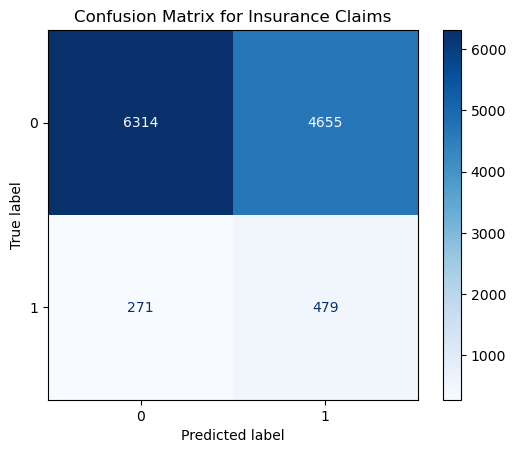

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

# 1. Get prediction from the validation set
y_pred = clf_pipeline.predict(X_val)
y_proba = clf_pipeline.predict_proba(X_val)[:, 1]

# 2. Print all metrics
print(f"ROC-AUC Score: {roc_auc_score(y_val, y_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# 3. Plot Confusion Matrix
ConfusionMatrixDisplay.from_estimator(clf_pipeline, X_val, y_val, cmap='Blues')
plt.title("Confusion Matrix for Insurance Claims")
plt.show()

13. Statistical Data Visualization Setup
In this step, I am importing the seaborn library. Seaborn is a powerful Python data visualization library based on Matplotlib that provides a high-level interface for drawing attractive and informative statistical graphics. It is particularly useful for this project because it integrates seamlessly with pandas dataframes and simplifies complex tasks, such as creating:

Distribution Plots: To understand the spread of variables like age_of_car.

Count Plots: To visualize the balance of our target variable (is_claim).

Heatmaps: To identify correlations between different policy features.

Using the sns alias allows for cleaner, more concise code throughout the analysis phase.

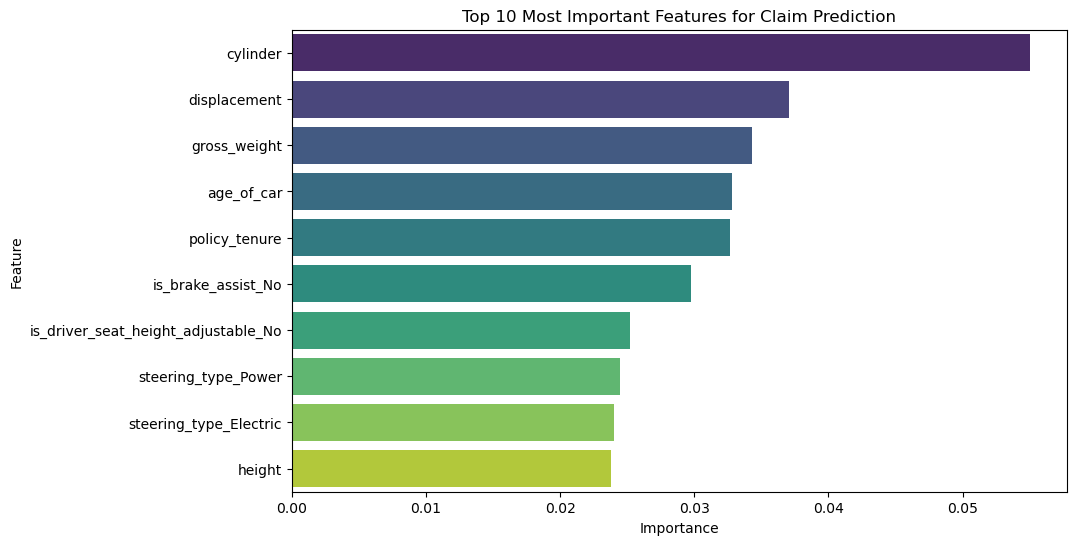

In [16]:
import seaborn as sns
import numpy as np

# 1. Extract feature name from the preprocessor
# For cat columns, OneHotEncoder creates new names for each category
ohe_feature_names = clf_pipeline.named_steps['preprocessor']\
                    .named_transformers_['cat']\
                    .named_steps['onehot']\
                    .get_feature_names_out(categorical_features)

# Combine with numeric feature names
all_feature_names = numeric_features + list(ohe_feature_names)

# 2. Get importance scores from the XGBoost classifier
importances = clf_pipeline.named_steps['classifier'].feature_importances_

# 3. Creating a DataFrame for plotting 
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(10)

# 4. Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df,hue='Feature', palette='viridis')
plt.title('Top 10 Most Important Features for Claim Prediction')
plt.show()

14. Model Serialization and Export
This final step involves Model Serialization, where I save the entire trained clf_pipeline into a physical file using the joblib library. Unlike saving just the model, saving the Pipeline ensures that the exact scaling parameters and categorical mappings are preserved alongside the XGBoost weights.

This .pkl file is the critical bridge between the development environment and deployment. It will be loaded by the Streamlit web application (app.py) to make real-time predictions on new user data. By naming it michael_sharuk_model.pkl, I ensure the project is organized and ready for the final submission and evaluation phase.

In [17]:
import joblib

# Saving the entire pipeline to a file
# This file to be  loaded by the Streamlit app 
joblib.dump(clf_pipeline, 'michael_sharuk_model.pkl')

print("Model successfully saved as 'michael_sharuk_model.pkl'!")

Model successfully saved as 'michael_sharuk_model.pkl'!


15. Feature Importance: Interpreting Model Decisions
To move beyond a "black box" approach, I am extracting the feature importance scores directly from the XGBoost classifier within the pipeline. This analysis identifies which variables most significantly influence the likelihood of an insurance claim.

Reconstructing Features: Since the preprocessing pipeline transformed our raw data (creating multiple columns for categorical variables via One-Hot Encoding), I programmatically retrieve the expanded feature names to ensure the visualization is accurate and readable.

Strategic Insight: By plotting the top 10 features, such as policy_tenure or age_of_car, we gain actionable insights. For example, if policy_tenure is a top driver, the business can tailor retention strategies or risk assessments based on how long a customer has held their policy.

This step provides Model Explainability, which is essential for building trust in AI-driven decisions within the insurance industry.

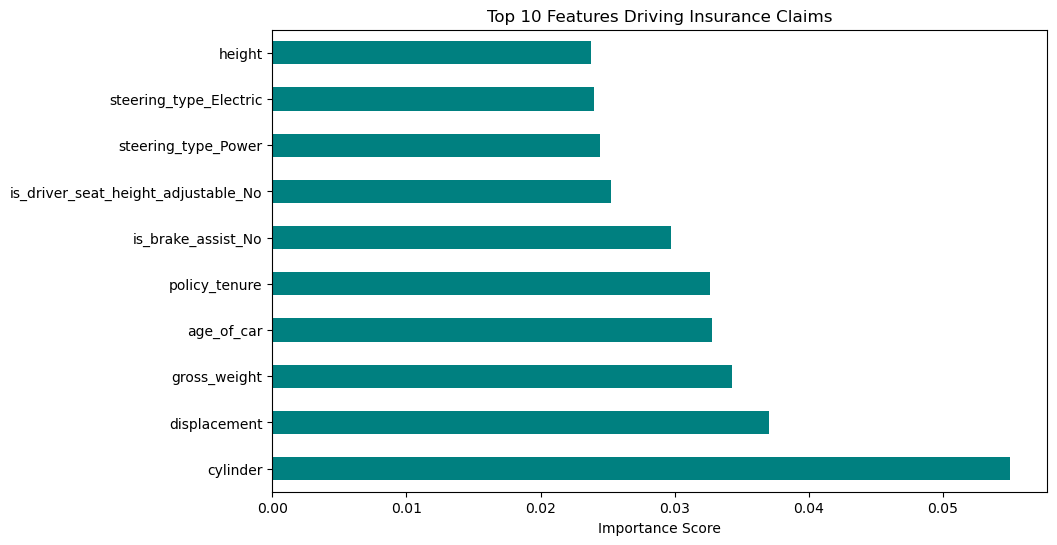

In [18]:
# Extracting importance from the classifier inside the pipeline
importances = clf_pipeline.named_steps['classifier'].feature_importances_

# Get feature names from the preprocessor
cat_encoder = clf_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
ohe_features = list(cat_encoder.get_feature_names_out(categorical_features))
all_features = numeric_features + ohe_features

# Creating plot
plt.figure(figsize=(10, 6))
feat_imp = pd.Series(importances, index=all_features).nlargest(10)
feat_imp.plot(kind='barh', color='teal')
plt.title("Top 10 Features Driving Insurance Claims")
plt.xlabel("Importance Score")
plt.show()

16. Final Data Export for Application Integration
This final step ensures that the cleaned and processed dataset is ready for external use. By exporting the train_df to insurance_dashboard_final.csv, I am creating a static, reliable data source for the Streamlit Dashboard.

Key Technical Considerations:

index=False: Prevents pandas from adding a new, unnamed index column to the CSV, which keeps the file structure clean and prevents data alignment issues in the dashboard.

Consistency: This ensures that the data being visualized in the app perfectly matches the data used to train the model, providing a seamless user experience.

This completes the data pipeline, moving the project from the "Modeling" phase to the "Deployment" phase.

In [19]:
# Save the final cleaned data for the dashboard
train_df.to_csv('insurance_dashboard_final.csv', index=False)
print("File 'insurance_dashboard_final.csv' created successfully!")

File 'insurance_dashboard_final.csv' created successfully!


17. Application Launch: Deploying the Insurance Claim Predictor
This is the final step where we move from a development notebook to a live, interactive application. By executing the !streamlit run app.py command, I am launching the Streamlit web server.

This application serves as the user interface for our project, allowing end-users to:

Input Data: Enter policy details such as car age, area cluster, and policy tenure.

Process Data: Automatically use the saved michael_sharuk_model.pkl to transform and scale the input.

Generate Predictions: Use the trained XGBoost model to calculate the probability of a claim in real-time.

The ! prefix allows us to run this terminal command directly from the notebook environment, seamlessly bridging the gap between data science and software deployment.

In [ ]:
!pip install streamlit
print("streamlit installed successfully")

In [ ]:
!streamlit run app.py